# Expedia Personalised Hotel Searches
VU Data Mining Techniques 2024 | Assignment 2 | Group 17

## Imports

In [1]:
import datetime
import gc
import lightgbm as lgb
from lightgbm.callback import early_stopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.impute import KNNImputer
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def downscale_and_save(df, filename):
    df_copy = df.copy()

    for col in df_copy.select_dtypes(include='float64').columns:
        df_copy[col] = df_copy[col].astype('float32')

    df_copy.to_csv(filename, index=False)

    del df_copy
    gc.collect()

## Data Preprocessing

In [3]:
train_df = pd.read_csv('data/training_set_VU_DM.csv', parse_dates=['date_time'])
test_df = pd.read_csv('data/test_set_VU_DM.csv', parse_dates=['date_time'])

In [4]:
# Creating the relevance target
train_df['relevance'] = train_df['booking_bool'] * 2 + (train_df['click_bool'] * (1 - train_df['booking_bool']))

#### Handling Datetime

In [5]:
# Extract useful features from 'date_time'
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df = train_df.drop(columns=['date_time'])

test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['day'] = test_df['date_time'].dt.day
test_df = test_df.drop(columns=['date_time'])

#### Removing Outliers

In [6]:
num_feats_with_outliers = ['price_usd', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']

for feature in num_feats_with_outliers:  # Based on EDA only price_usd & compX_rate_percent_diff
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Replace outliers with NaN
    train_df.loc[~train_df[feature].between(lower_bound, upper_bound), feature] = np.nan

#### Selecting Subset of Records
Selecting a subset of records based on number of missing values in each record

In [7]:
# Calculate the count of missing values in each row
train_df['missing_count'] = train_df.isnull().sum(axis=1)

# Sort the dataframe by 'missing_count' in ascending order
train_df = train_df.sort_values(by='missing_count')

# Select the top x% of the rows with the least missing values
top_percentage = 0.75
cut_off = int(len(train_df) * top_percentage)
train_df = train_df.iloc[:cut_off]
print(len(train_df))

3718760


#### Handling Missing Values

In [8]:
# imputer = KNNImputer(n_neighbors=5)
# train_df[:] = imputer.fit_transform(train_df)

### Feature Engineering

#### Mean Position

In [9]:
mean_positions = train_df[train_df['random_bool'] == False].groupby('prop_id')['position'].mean().rename('mean_train_position')  # Exclude records where the results order is random
train_df = train_df.join(mean_positions, on='prop_id')
test_df = test_df.join(mean_positions, on='prop_id')

#### Click/Booking Prior Probability

In [10]:
def compute_prior(df, group_field, value_field):
    # Sum and count values per group
    sums = df.groupby(group_field)[value_field].transform('sum')
    count = df.groupby(group_field)[value_field].transform('count')
    
    # Calculate leave-one-out prior
    prior = (sums - df[value_field]) / (count - 1)
    return prior

In [11]:
# Apply function for click and booking bool
train_df['click_prior'] = compute_prior(train_df, 'prop_id', 'click_bool')
train_df['booking_prior'] = compute_prior(train_df, 'prop_id', 'booking_bool')

# Handling cases with only one record per group
train_df.fillna({'click_prior': train_df['click_bool'].mean()}, inplace=True)
train_df.fillna({'booking_prior': train_df['booking_bool'].mean()}, inplace=True)

In [12]:
# Priors for click and booking bool from the training set
test_df['click_prior'] = test_df['prop_id'].map(train_df.groupby('prop_id')['click_bool'].mean())
test_df['booking_prior'] = test_df['prop_id'].map(train_df.groupby('prop_id')['booking_bool'].mean())

# Handling cases with only one record per group
test_df.fillna({'click_prior': train_df['click_bool'].mean()}, inplace=True)
test_df.fillna({'booking_prior': train_df['booking_bool'].mean()}, inplace=True)

#### # of Prior Searches

In [13]:
# Number of occurences "minus the current row"
train_df['previous_searches'] = train_df.groupby('prop_id')['prop_id'].transform('count') - 1
test_df['previous_searches'] = test_df['prop_id'].map(train_df.value_counts('prop_id') - 1).fillna(0)

#### Number of Bookings for Property/Destination Combination

In [14]:
# Aggregate number of bookings for each property and destination combination
booking_counts = train_df.groupby(['prop_id', 'srch_destination_id'])['booking_bool'].sum().reset_index()
booking_counts.rename(columns={'booking_bool': 'booking_count'}, inplace=True)

# Merge this count back to the train and test datasets
train_df = train_df.merge(booking_counts, on=['prop_id', 'srch_destination_id'], how='left')
test_df = test_df.merge(booking_counts, on=['prop_id', 'srch_destination_id'], how='left')

#### Mean Distance to Other Properties in the Query

In [15]:
# Calculate the maximum difference in distance to the user within each search query
max_distance_diff = train_df.groupby('srch_id')['orig_destination_distance'].transform(lambda x: x.max() - x.min())

# Add this as a feature
train_df['max_distance_diff'] = max_distance_diff

# Compute the mean of these maximum differences by property and add it back to the dataset
mean_distance = train_df.groupby('prop_id')['max_distance_diff'].mean().reset_index()
mean_distance.rename(columns={'max_distance_diff': 'mean_max_distance_diff'}, inplace=True)

train_df = train_df.merge(mean_distance, on='prop_id', how='left')
test_df = test_df.merge(mean_distance, on='prop_id', how='left')

# TODO: Add to the test set too

#### Statistical Features

In [16]:
features_to_stat = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'orig_destination_distance', 'srch_query_affinity_score', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count']  # Perhaps change this based on LightGBM.feature_importances_

for feature in tqdm(features_to_stat):
    stats = train_df.groupby('prop_id')[feature].agg(['mean', 'median', 'std']).rename(
        columns={'mean': f'{feature}_mean', 'median': f'{feature}_median', 'std': f'{feature}_std'})
    train_df = train_df.join(stats, on='prop_id')

100%|██████████| 15/15 [01:24<00:00,  5.64s/it]


In [17]:
for feature in tqdm(features_to_stat):
    stats = train_df.groupby('prop_id')[feature].agg(['mean', 'median', 'std']).rename(
        columns={'mean': f'{feature}_mean', 'median': f'{feature}_median', 'std': f'{feature}_std'})
    test_df = test_df.join(stats, on='prop_id')

100%|██████████| 15/15 [02:24<00:00,  9.61s/it]


### Saving the Processed Data

In [18]:
downscale_and_save(train_df, 'data/processed_train.csv')
downscale_and_save(test_df, 'data/processed_test.csv')

# Modeling

In [19]:
train_df = pd.read_csv('data/processed_train.csv')
test_df = pd.read_csv('data/processed_test.csv')

#### Feature Grouping

In [20]:
boolean_features = ['prop_brand_bool', 'promotion_flag', 'srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool']
categorical_features = ['site_id', 'visitor_location_country_id', 'prop_country_id', 'srch_id', 'prop_id', 'srch_destination_id']
numerical_features = [col for col in train_df.columns if col not in boolean_features + categorical_features + ['relevance']]

In [21]:
missing_feats = set(train_df.columns) - set(test_df.columns)
missing_feats

{'booking_bool',
 'click_bool',
 'gross_bookings_usd',
 'max_distance_diff',
 'missing_count',
 'position',
 'relevance'}

In [22]:
features = train_df.columns.difference(['srch_id', 'prop_id', 'booking_bool', 'click_bool', 'relevance', ] + list(missing_feats))
for f in features:
    print(f)

booking_count
booking_prior
click_prior
comp1_inv
comp1_rate
comp1_rate_percent_diff
comp2_inv
comp2_rate
comp2_rate_percent_diff
comp3_inv
comp3_rate
comp3_rate_percent_diff
comp4_inv
comp4_rate
comp4_rate_percent_diff
comp5_inv
comp5_rate
comp5_rate_percent_diff
comp6_inv
comp6_rate
comp6_rate_percent_diff
comp7_inv
comp7_rate
comp7_rate_percent_diff
comp8_inv
comp8_rate
comp8_rate_percent_diff
day
mean_max_distance_diff
mean_train_position
month
orig_destination_distance
orig_destination_distance_mean
orig_destination_distance_median
orig_destination_distance_std
previous_searches
price_usd
price_usd_mean
price_usd_median
price_usd_std
promotion_flag
prop_brand_bool
prop_country_id
prop_location_score1
prop_location_score1_mean
prop_location_score1_median
prop_location_score1_std
prop_location_score2
prop_location_score2_mean
prop_location_score2_median
prop_location_score2_std
prop_log_historical_price
prop_log_historical_price_mean
prop_log_historical_price_median
prop_log_histori

In [23]:
# Grouping by 'srch_id' before splitting to maintain groups
grouped = train_df.groupby('srch_id')
gss = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_inds, val_inds = next(gss.split(train_df, groups=train_df['srch_id']))

In [24]:
# Group sizes for LightGBM
train_group = train_df.iloc[train_inds].groupby('srch_id').size().values
val_group = train_df.iloc[val_inds].groupby('srch_id').size().values

In [25]:
X_train, y_train = train_df[features].iloc[train_inds], train_df['relevance'].iloc[train_inds]
X_val, y_val = train_df[features].iloc[val_inds], train_df['relevance'].iloc[val_inds]
X_test = test_df[features]

assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

In [26]:
param_grid = {
    'learning_rate': [0.01, 0.05],
    'subsample': [0.5, 0.8, 1],
}

In [28]:
# categorical features should be the categorical features minus the ones that are not in the features
categorical_features = [f for f in categorical_features if f in features]
best_score = -float('inf')
best_params = {}

# Iterate over all combinations of parameters
for params in tqdm(ParameterGrid(param_grid)):
    model = lgb.LGBMRanker(
        objective='lambdarank',
        boosting_type='dart',
        importance_type='gain',
        metric='ndcg',
        label_gain=[0, 1, 10],
        num_leaves=15,
        n_estimators=50,
        reg_alpha=0.2,
        reg_lambda=0.2,
        verbose=0,
        **params
    )
    model.fit(
        X_train,
        y_train,
        group=train_group,
        eval_set=[(X_val, y_val)],
        eval_group=[val_group],
        eval_at=[5],
        categorical_feature=categorical_features,
        # callbacks=[early_stopping(10)]
    )
    
    # Evaluate the model
    y_pred_val = model.predict(X_val)
    score = ndcg_score([y_val], [y_pred_val])

    # Save the best model
    if score > best_score:
        best_score = score
        best_params = params
        model.booster_.save_model('best_lambdaMART_model.txt')


print('-' * 50)
print(f'Best NDCG Score: {best_score}')
print(f'Best Parameters: {best_params}')

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 17%|█▋        | 1/6 [00:33<02:47, 33.42s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 33%|███▎      | 2/6 [00:58<01:53, 28.33s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 50%|█████     | 3/6 [01:22<01:19, 26.49s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 67%|██████▋   | 4/6 [01:50<00:53, 26.96s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 83%|████████▎ | 5/6 [02:20<00:28, 28.10s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


100%|██████████| 6/6 [02:47<00:00, 27.95s/it]

--------------------------------------------------
Best NDCG Score: 0.8919280296803449
Best Parameters: {'learning_rate': 0.05, 'subsample': 0.5}


In [29]:
# Format the date and time as a string
datetime_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model = lgb.Booster(model_file=f'best_lambdamart_model_{datetime_string}.txt')

<Axes: title={'center': 'Feature Importance by Split'}, xlabel='Feature importance', ylabel='Features'>

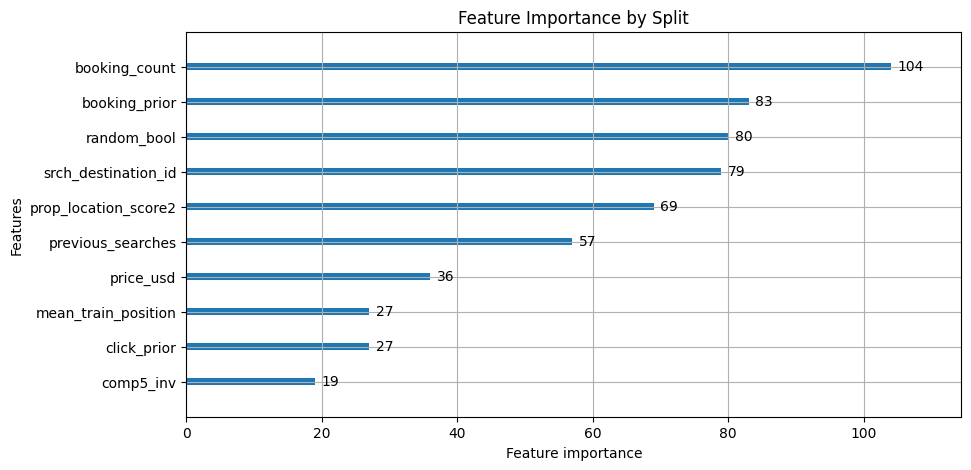

In [30]:
lgb.plot_importance(model, importance_type='split', max_num_features=10, figsize=(10, 5), title='Feature Importance by Split')

In [31]:
# Predict on the test set
y_pred = model.predict(X_test)

# Add predictions to the test set
test_df['predicted_score'] = y_pred

# Select only the required columns
test_df = test_df[['srch_id', 'prop_id', 'predicted_score']]

# Sort properties for each search by predicted score
test_df = test_df.sort_values(by=['srch_id', 'predicted_score'], ascending=[True, False])

# Create the submission file in the required format
submission = test_df[['srch_id', 'prop_id']]

# Format the date and time as a string
datetime_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the submission file with the date and time in the filename
submission.to_csv(f'/submissions/lambdaMART_submission_{datetime_string}.csv', index=False)

# Verify the submission file format
print(submission.head(5))
print(f'Submission shape: {submission.shape}')

    srch_id  prop_id
5         1    28181
0         1     3180
28        1   139162
9         1    54937
12        1    61934
Submission shape: (4959183, 2)
